### Open test downloaded Powder Patch data from Mesonet 

Notebook contents 
* opening test data download to get a feel of things before downloading many years

created by Cassie Lumbrazo\
last updated: Jan 2025\
run location: UAS linux\
python environment: **xarray**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
pwd

'/home/cassie/python/repos/juneau_data_analysis'

## Data Source 
So, the API request was not working for Powder Patch. I could only identify the Juneau Airport from that API. Rather, I've downloaded some test data from Mesonet (https://mesonet2.agron.iastate.edu/request/dcp/fe.phtml?network=AK_DCP)

[`PPSA2`] POWDER PATCH STATION (20..)

There are a few stations identifed on Douglas Island, so I think I'll have to download data from each one and put them together to create a complete dataset. 

For now, we can open the one from `PPSA2` to see what variables are in there.

In [4]:
filename = '/home/cassie/data/eaglecrest/mesonet_datadownload_test_powderpatch.txt'

# open
# df = pd.read_csv(filename, skiprows=1, sep='\t', parse_dates=True, index_col='datetime')
df = pd.read_csv(filename, sep = ",")
df

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ
0,PPSA2,2023-10-16 18:00:00,128.62,0.00,49.7,63.04
1,PPSA2,2023-10-16 19:00:00,128.62,0.00,50.5,59.44
2,PPSA2,2023-10-16 20:00:00,128.62,0.00,48.2,72.65
3,PPSA2,2023-10-16 21:00:00,128.62,0.00,48.3,71.85
4,PPSA2,2023-10-16 22:00:00,128.62,0.00,48.4,72.42
...,...,...,...,...,...,...
7627,PPSA2,2024-09-29 20:00:00,278.46,14.36,40.4,91.40
7628,PPSA2,2024-09-29 21:00:00,278.46,16.34,39.9,88.20
7629,PPSA2,2024-09-29 22:00:00,278.46,16.56,40.4,88.60
7630,PPSA2,2024-09-29 23:00:00,278.46,15.25,40.8,88.00


From the SHEF Code Manual (chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.weather.gov/media/mdl/SHEF_CodeManual_5July2012.pdf)

We can get the header info, 
* PCIRZZZ: Accumulated precipitation (in) (PC = PCIRZZZ)
* SDIRZZZ: (not in manual)
* TAIRZZZ: Temperature (DC) (TA = TAIRZZZ)
* XRIRZZZ: (not in manual)

In [5]:
# Trying the variable names here to see what we can fill in based on other code, 
# PCIRZZZ: 24 hour precip
# SDIRZZZ: 24 hour snowfall
# TAIRZZZ: 24 hour max temp
# XRIRZZZ: 24 hour min temp

In [6]:
# make utc_valid a datetime and index the df by it 
df['datetime'] = pd.to_datetime(df['utc_valid'])
df = df.set_index('datetime')
df.head()

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ
datetime,,,,,,
2023-10-16 18:00:00,PPSA2,2023-10-16 18:00:00,128.62,0.0,49.7,63.04
2023-10-16 19:00:00,PPSA2,2023-10-16 19:00:00,128.62,0.0,50.5,59.44
2023-10-16 20:00:00,PPSA2,2023-10-16 20:00:00,128.62,0.0,48.2,72.65
2023-10-16 21:00:00,PPSA2,2023-10-16 21:00:00,128.62,0.0,48.3,71.85
2023-10-16 22:00:00,PPSA2,2023-10-16 22:00:00,128.62,0.0,48.4,72.42


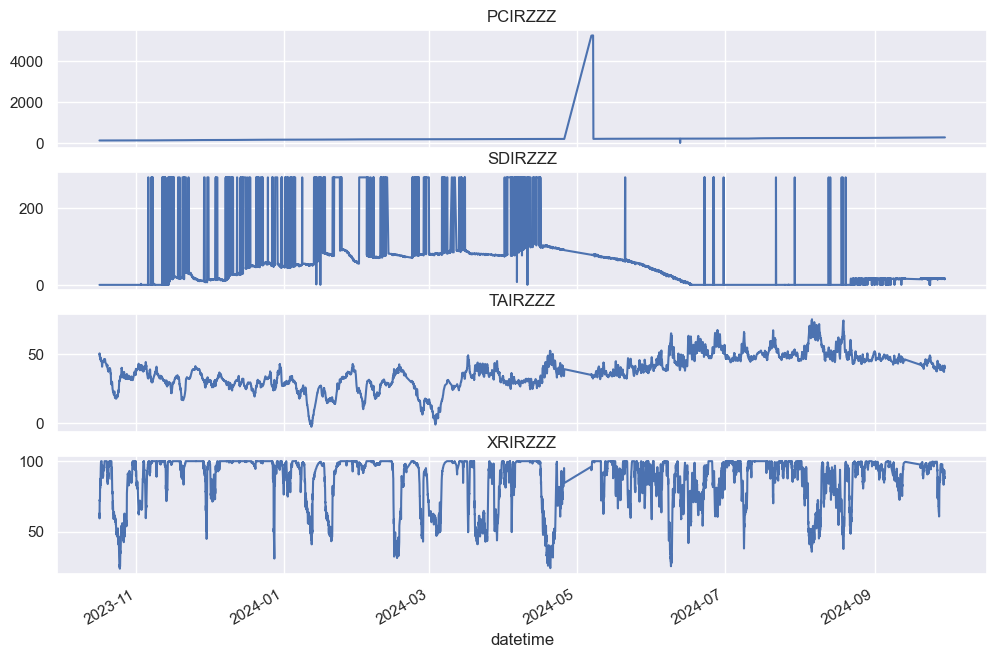

In [7]:
# plot all four variables with datetime to see what they are 
fig, ax = plt.subplots(4,1, figsize=(12,8), sharex=True)
df['PCIRZZZ'].plot(ax=ax[0])
df['SDIRZZZ'].plot(ax=ax[1])
df['TAIRZZZ'].plot(ax=ax[2])
df['XRIRZZZ'].plot(ax=ax[3])

# add titles to all the plots with the variable names 
ax[0].set_title('PCIRZZZ')
ax[1].set_title('SDIRZZZ')
ax[2].set_title('TAIRZZZ')
ax[3].set_title('XRIRZZZ')

plt.show()

It looks like there are some large values in df[`PCIRZZZ`] and df[`SDIRZZZ`] so we will need to remove those to see the data more clearly. But for now it looks like we have, 
* PCIRZZZ: some form of precip 
* SDIRZZZ: total snow depth
* TAIRZZZ: air temperature (avg, min, max idk) in F
* XRIRZZZ: relative humidity 

In [8]:
# drop station and utc_valid columns
df = df.drop(columns=['station', 'utc_valid'])

# rename column names to make this easier 
df.columns = ['pc', 'hs', 'ta', 'rh']
df.head()

,pc,hs,ta,rh
datetime,,,,
2023-10-16 18:00:00,128.62,0.0,49.7,63.04
2023-10-16 19:00:00,128.62,0.0,50.5,59.44
2023-10-16 20:00:00,128.62,0.0,48.2,72.65
2023-10-16 21:00:00,128.62,0.0,48.3,71.85
2023-10-16 22:00:00,128.62,0.0,48.4,72.42


In [9]:
# find where pc is greater than 1000 and make all those values nan in the dataset 
df.loc[df['pc'] > 1000, 'pc'] = np.nan
df.loc[df['pc'] < 100, 'pc'] = np.nan

# make nan where hs is greater than 200
df.loc[df['hs'] > 200, 'hs'] = np.nan
df.loc[df['hs'] < 0, 'hs'] = np.nan

# change ta from F to C 
df['ta'] = (df['ta'] - 32) * 5/9

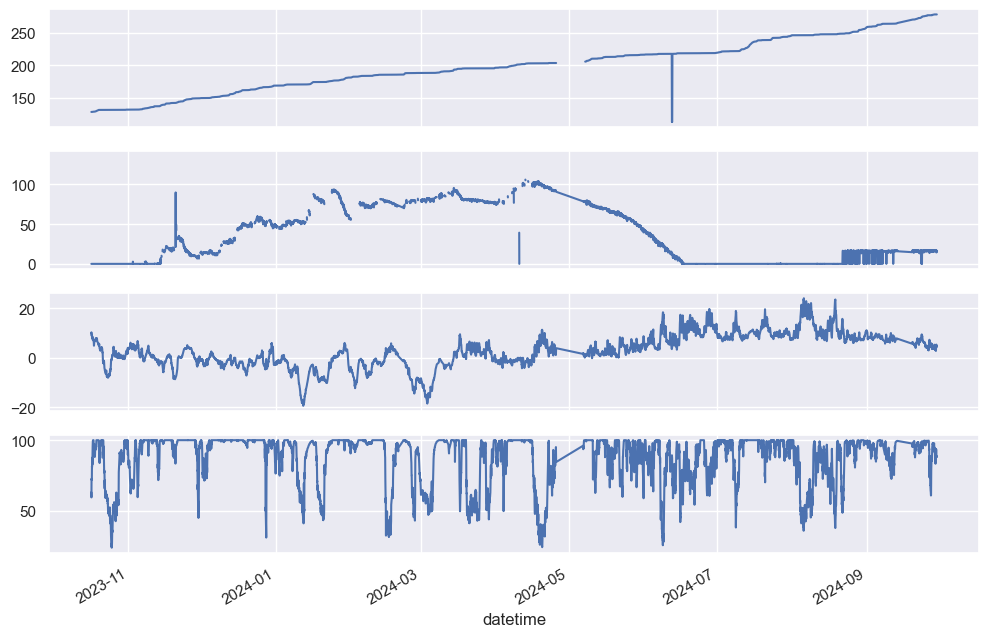

In [10]:
# plot all four variables with datetime to see what they are 
fig, ax = plt.subplots(4,1, figsize=(12,8), sharex=True)
df['pc'].plot(ax=ax[0], label='pc')
df['hs'].plot(ax=ax[1], label='hs')
df['ta'].plot(ax=ax[2], label='ta')
df['rh'].plot(ax=ax[3], label='rh')
plt.show()

### From the Mesonet Website, 
#### the following data is all listed from different stations with unique names and station_id
url: https://mesonet2.agron.iastate.edu/request/dcp/fe.phtml?network=AK_DCP

Station 1:
* Name: Douglas - Eaglecrest 
* SID: ETBA2 
* Period: (2015-2022)

Station 2
* Name: Douglas - Eaglecrest 
* SID: JECA2
* Period: (2023- Now)

Station 3
* Name: EAGLECREST TOP
* SID: ECTA2
* Period: (2010 - Now)

Station 4
* Name: Juneau 4SW - Eaglecrest 
* SID: ECEA2
* Period: (2021 - Now)

Station 4
* Name: POWDER PATCH
* SID: PPSA2
* Period: (2010 - Now)

And the data above is from Station 4: Powder Patch, PPSA2

__________________
### So, I've downloaded data from 1 Oct 2023 to 30 Sept 2024 from all of the stations listed above (downloaded together)

Let's take a look at that file and see what's in there...

In [ ]:
filename = '/home/cassie/data/eaglecrest/mesonet_datadownload_test_all_eaglecrest_stations.txt'

# open
df = pd.read_csv(filename, sep = ",")
df

,station,utc_valid,PCIRZZZ,PPDRZZZ,PPIRZZZ,PPPRZZZ,PPVRZZZ,PTIRZZZ,PTPRZZZ,SDIRZZZ,...,USPRZZZ,VVIRZZZ,VVPRZZZ,XCIRZZZ,XCPRZZZ,XPPRZZZ,XPQRZZZ,XRIRZZZ,XWIRZZZ,XWPRZZZ
0,ECEA2,2023-10-01 00:00:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
1,ECEA2,2023-10-01 00:05:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2,ECEA2,2023-10-01 00:10:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
3,ECEA2,2023-10-01 00:15:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
4,ECEA2,2023-10-01 00:20:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612832,PPSA2,2024-09-29 20:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,14.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.4,NaN,NaN
612833,PPSA2,2024-09-29 21:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,16.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.2,NaN,NaN
612834,PPSA2,2024-09-29 22:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,16.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.6,NaN,NaN
612835,PPSA2,2024-09-29 23:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,15.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN,NaN


In [ ]:
# make utc_valid a datetime and index the df by it 
df['datetime'] = pd.to_datetime(df['utc_valid'])
df = df.set_index('datetime')
df.head()

,station,utc_valid,PCIRZZZ,PPDRZZZ,PPIRZZZ,PPPRZZZ,PPVRZZZ,PTIRZZZ,PTPRZZZ,SDIRZZZ,...,USPRZZZ,VVIRZZZ,VVPRZZZ,XCIRZZZ,XCPRZZZ,XPPRZZZ,XPQRZZZ,XRIRZZZ,XWIRZZZ,XWPRZZZ
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,ECEA2,2023-10-01 00:00:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:05:00,ECEA2,2023-10-01 00:05:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:10:00,ECEA2,2023-10-01 00:10:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:15:00,ECEA2,2023-10-01 00:15:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:20:00,ECEA2,2023-10-01 00:20:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN


I think the easiest way to do data exploration here with all the stations together will be with plotly... 

In [13]:
import plotly
import plotly.express as px 

In [14]:
df.station.unique()

array(['ECEA2', 'ECTA2', 'JECA2', 'PPSA2'], dtype=object)

In preliminary plots we had some huge values, so let's just remove those so that we can see the datasets a bit better...

In [25]:
# do a very small cleaning to reduce large errors when plotting
# remove any values in the dataset over 500 
numeric_cols = df.select_dtypes(include=[np.number]).columns # identify the numeric columns only 
df[numeric_cols] = df[numeric_cols].where(df[numeric_cols] < 500, np.nan) # pandas where function keeps values that are true, and replaces values that are false with the value in the third argument

# This does not work because we have some string columns in the dataset
# df.where(df < 500, np.nan, inplace=True) # pandas where function keeps values that are true, and replaces values that are false with the value in the third argument

So, I actually downloaded data from "6" stations. 5 labeled above, then EAGLECREST TOP [`ECTA2`] was listed twice. So based on the fact that there are only 4 unqiue stations, then that means one did not have data from WY2024, which we know is `ETBA2` and the other will be the second `ECTA2`. That checks out. 

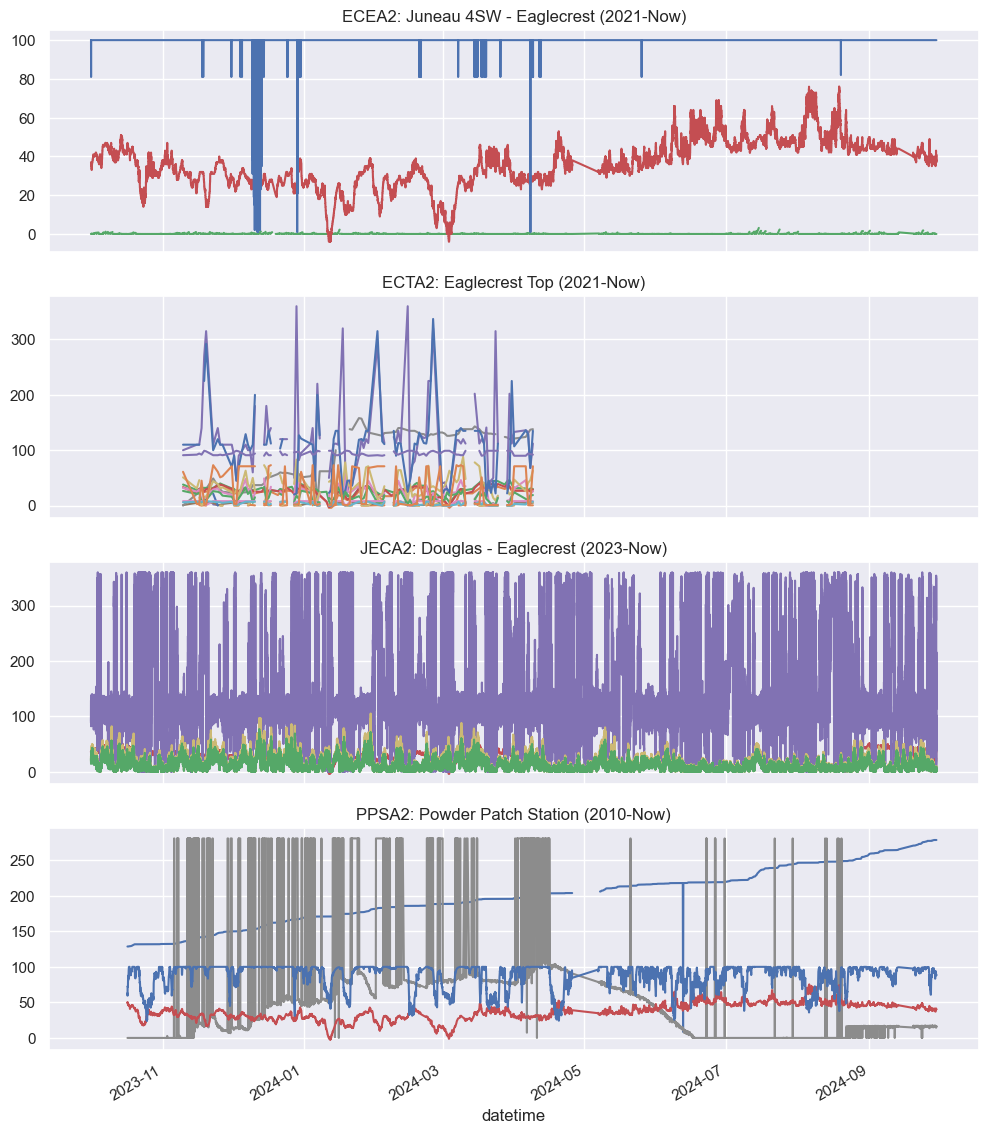

In [26]:
# so let's plot the data by station
fig, ax = plt.subplots(4,1, figsize=(12,15), sharex=True)

df.where(df['station'] == 'ECEA2').plot(ax=ax[0], label='ECEA2', legend=False)
df.where(df['station'] == 'ECTA2').plot(ax=ax[1], label='ECTA2', legend=False)
df.where(df['station'] == 'JECA2').plot(ax=ax[2], label='JECA2', legend=False)
df.where(df['station'] == 'PPSA2').plot(ax=ax[3], label='PPSA2', legend=False)

# add a title for each station name
ax[0].set_title('ECEA2: Juneau 4SW - Eaglecrest (2021-Now)')
ax[1].set_title('ECTA2: Eaglecrest Top (2021-Now)')
ax[2].set_title('JECA2: Douglas - Eaglecrest (2023-Now)')
ax[3].set_title('PPSA2: Powder Patch Station (2010-Now)')

plt.show()

So, we can take a few guesses based on what we see... for most things. For the rest, we checked the data source into provided below. 

### ETBA2: Douglas - Eaglecrest (2015-2022)
*data not downloaded* 

but I do assume that it's a just the older version for the site below (pre-2023)

### JECA2: Douglas - Eaglecrest (2023- Now)
Metasdata Source: https://mesonet2.agron.iastate.edu/sites/current.php?network=AK_DCP&station=JECA2
* TA: temperature, air, dry bulb (unit: F)
* UD: wind direction (unit: )
* UP: peak wind speed 
* US: wind speed 

### ECTA2: EAGLECREST TOP (2010 - Now)
Metadata Source: https://mesonet2.agron.iastate.edu/sites/current.php?network=AK_DCP&station=ECTA2

*all of these precipitation readings are different in duration, 1 day 1 hour 1 week, etc.*
* PP: precipitation (includes liquid amount of new snowfall) (24 hr precipitation, liquid)
* PT: precipitation type (unit: ) 
* SD: snow depth (unit: in or cm)
* SF: snow depth, new snowfall (unit: in or cm) (1 DAY) (24 hr snowfall)
* TA: temperature, air, dry bulb, max of day (unit: F)
* TA: temperature, air, dry bulb, min of day (unit: F)
* TA: temperature, air, dry bulb (unit: F)
* UD: wind direction (unit: )
* UG: wind guest at observation time 
* UP: peak wind speed 
* UR: peak wind direction associated with peak wind speed 
* US: wind speed (unit: )
* VV: unknown code 
* XP: total sky cover (unit: )
* XP: weather, past NWS synoptic code (6 hour)
* XW: weather, present NWS synoptic code (instantaneous) 

SW is not here, but if it was it would be snow water equivalent of the accumulated snow depth of snow on the ground (from Code Manual)


### ECEA2: Juneau 4SW - Eaglecrest (2021 - Now)
Metadata Source: https://mesonet2.agron.iastate.edu/sites/current.php?network=AK_DCP&station=ECEA2
* PP: precipitation (includes liquid amount of new snowfall) (unit: )
* TA: temperature, air, dry bulb (unit: F)
* XR: relative humidity (unit: %)

### PPSA: POWDER PATCH (2010 - Now)
Metadata Source: https://mesonet2.agron.iastate.edu/sites/current.php?station=PPSA2&network=AK_DCP
* SD: snow depth (unit: in?)
* TA: temperature, air, dry bulb (unit: F)
* PC: accumulated precipitation (unit: in)
* XR: relative humidity (unit: %)